# Machine Learning with Graphs - Final Exam Notebook  
**Authors:** Amine RAZIG & Abdoul Zeba  

## Introduction  

This notebook implements graph-based weather forecasting for our *Machine Learning with Graphs* final exam. Building on concepts from ["Probabilistic Weather Forecasting with Hierarchical Graph Neural Networks"](), we present a simplified GNN architecture that maintains some of the core ideas while being more accessible for implementation. We applied to **ERA5 reanalysis data** from the Copernicus Climate Data Store, with focus on the **Northwest coast of France**.

### Dataset & Region Focus  
**ERA5 Data Features**:  
- Source: Copernicus Climate Data Store  
- Variables:  
  - 2m temperature (`t2m`)  
  - 10m u/v wind components (`u10`, `v10`) 

### Motivation  
We develop a basic but functional version of:
- **Hierarchical graph processing** (3-level architecture)
- **Variational encoding** (μ/σ latent space)
- **Multi-step forecasting** (t+1 to t+n predictions)

### Key Differences from Reference Paper  
| Our Implementation | Original Paper |
|--------------------|----------------|
| Basic 3-level hierarchy | Complex multi-scale architecture |
| Single VGCN encoder | Advanced probabilistic modules |
| Focused on few concepts | Production-ready system |

### Notebook Structure  
0. **Toy example**
1. **Data Preparation**: Graph construction from weather stations  
2. **Model Architecture**: VGCN encoder-decoder implementation  
3. **Training**: Loss function and optimization  
4. **Evaluation**: Predictions vs ground truth visualization  

*"While simplified, our implementation preserves the essential graph-to-graph forecasting paradigm of the original work."*  

➡️ The complete code is available in subsequent sections.

In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

In [2]:
import xarray as xr
import pandas as pd
import os

# Chemin vers le dossier contenant les fichiers .nc
data_dir = "data/"

# Liste des fichiers .nc
nc_files = [
    "2m_temperature_0_daily-mean.nc",
    "10m_u_component_of_wind_stream-oper_daily-mean.nc",
    "10m_v_component_of_wind_0_daily-mean.nc",
    "total_precipitation_0_daily-mean.nc"
]

# Charger les fichiers NetCDF dans un dictionnaire de datasets
datasets = {}
for file in nc_files:
    file_path = os.path.join(data_dir, file)
    ds = xr.open_dataset(file_path)
    datasets[file] = ds
    print(f"Fichier chargé : {file}")
    print(ds)  # Afficher la structure du fichier

# Exemple : Explorer les données de température
temp_ds = datasets["2m_temperature_0_daily-mean.nc"]
print("Variables disponibles :", list(temp_ds.variables))
print("Dimensions :", temp_ds.dims)
print("Coordonnées :", temp_ds.coords)

# Convertir en DataFrame pour manipulation
temp_df = temp_ds.to_dataframe().reset_index()
print(temp_df.head())

# Nettoyer les données (exemple : supprimer les NaN)
temp_df_cleaned = temp_df.dropna()
print("Données nettoyées :")
print(temp_df_cleaned.head())

# Fusionner les données de plusieurs fichiers (exemple : température et vent)
u_wind_ds = datasets["10m_u_component_of_wind_stream-oper_daily-mean.nc"]
v_wind_ds = datasets["10m_v_component_of_wind_0_daily-mean.nc"]

# Convertir en DataFrames
u_wind_df = u_wind_ds.to_dataframe().reset_index()
v_wind_df = v_wind_ds.to_dataframe().reset_index()

# Fusionner les DataFrames sur les colonnes communes (exemple : time, latitude, longitude)
# Fusionner les DataFrames sur les colonnes communes (exemple : time, latitude, longitude)
merged_df = pd.merge(temp_df_cleaned, u_wind_df, on=["valid_time", "latitude", "longitude"])
merged_df = pd.merge(merged_df, v_wind_df, on=["valid_time", "latitude", "longitude"])
print("Données fusionnées :")
print(merged_df.head())

Fichier chargé : 2m_temperature_0_daily-mean.nc
<xarray.Dataset> Size: 25kB
Dimensions:     (valid_time: 31, latitude: 10, longitude: 20)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 80B 50.61 50.36 50.11 ... 48.86 48.61 48.36
  * longitude   (longitude) float64 160B -1.46 -1.21 -0.96 ... 2.79 3.04 3.29
  * valid_time  (valid_time) datetime64[ns] 248B 2024-10-01 ... 2024-10-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 25kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-18T09:16 GRIB to CDM+CF via cfgrib-0.9.1...
Fichier chargé : 10m_u_component_of_wind_stream-oper_daily-mean.nc
<xarray.Dataset> Size: 25kB
Dimensions:     (valid_time: 31, latitude: 10, longitude

In [3]:
merged_df

valid_time  latitude  longitude         t2m  number_x       u10  \
0    2024-10-01     50.61      -1.46  287.027130         0  5.891641   
1    2024-10-01     50.61      -1.21  286.772522         0  6.031213   
2    2024-10-01     50.61      -0.96  287.039825         0  6.910450   
3    2024-10-01     50.61      -0.71  287.251373         0  7.634367   
4    2024-10-01     50.61      -0.46  287.338379         0  8.157102   
...         ...       ...        ...         ...       ...       ...   
6195 2024-10-31     48.36       2.29  283.436798         0 -2.174011   
6196 2024-10-31     48.36       2.54  283.398285         0 -2.063164   
6197 2024-10-31     48.36       2.79  283.367462         0 -2.001111   
6198 2024-10-31     48.36       3.04  283.360077         0 -2.027885   
6199 2024-10-31     48.36       3.29  283.306671         0 -1.982038   

      number_y       v10  number  
0            0 -4.007300       0  
1            0 -3.749726       0  
2            0 -3.886445       0  
3            0 -4.007127       0  
4            0 -4.026770       0  
...        ...       ...     ...  
6195         0 -0.324510       0  
6196         0 -0.320021       0  
6197         0 -0.285348       0  
6198         0 -0.257127       0  
6199         0 -0.226397       0  

[6200 rows x 9 columns]

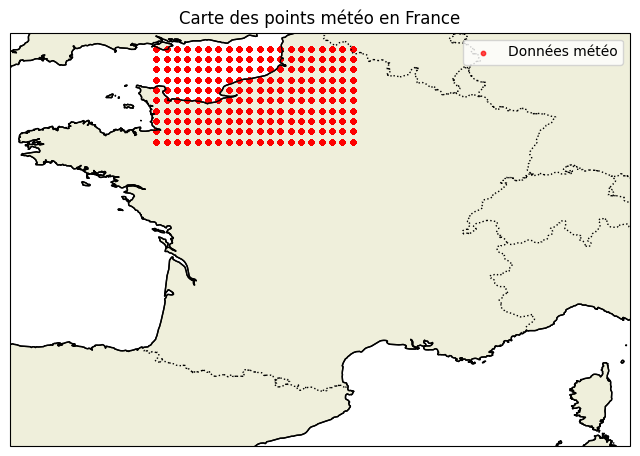

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Ajouter les frontières des pays et côtes
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Centrer sur la France
ax.set_extent([-5, 10, 41, 51])  # [lon_min, lon_max, lat_min, lat_max]

# Ajouter les points météo
ax.scatter(merged_df["longitude"], merged_df["latitude"], color='red', s=10, label="Données météo", alpha=0.7)

# Ajouter une légende et un titre
plt.legend()
plt.title("Carte des points météo en France")

# Sauvegarder l'image en PNG
plt.savefig("carte_meteo.png", dpi=300)
plt.show()


In [5]:
import folium
import pandas as pd


# Créer une carte centrée sur la France
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

# Ajouter les points météo sur la carte
for _, row in merged_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
    ).add_to(m)

# Sauvegarder et afficher la carte
m.save("carte_meteo.html")
print("Carte enregistrée sous 'carte_meteo.html'. Ouvrez ce fichier dans un navigateur pour la voir.")


Carte enregistrée sous 'carte_meteo.html'. Ouvrez ce fichier dans un navigateur pour la voir.


In [6]:
from IPython.display import display
display(m)

## 0. Toy example - Manual hierarchical graph construction

This section aims to illustrate the hierarchical graph construction highlighted in the paper of interest.

In [7]:
import torch
import numpy as np
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

# Fonction pour créer le graphe initial
def create_initial_graph(df, spatial_radius=1.0):
    # Extraire les coordonnées (latitude, longitude) et le temps
    coordinates = df[["latitude", "longitude"]].values
    times = df["valid_time"].values.astype('datetime64[s]').astype(np.int64)  # Convertir en timestamp
    
    # Créer des nœuds uniques pour chaque (latitude, longitude, time)
    nodes = np.hstack([coordinates, times.reshape(-1, 1)])
    
    # Créer des arêtes spatiales (voisinage géographique)
    nbrs = NearestNeighbors(radius=spatial_radius).fit(coordinates)
    distances, indices = nbrs.radius_neighbors(coordinates)
    edge_index_spatial = []
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                edge_index_spatial.append([i, j])
    edge_index_spatial = torch.tensor(edge_index_spatial, dtype=torch.long).t().contiguous()
    
    # Créer des arêtes temporelles (évolution dans le temps)
    edge_index_temporal = []
    unique_times = np.unique(times)
    for t in unique_times[:-1]:
        current_indices = np.where(times == t)[0]
        next_indices = np.where(times == t + 1)[0]
        for i in current_indices:
            for j in next_indices:
                if np.allclose(coordinates[i], coordinates[j]):  # Même emplacement
                    edge_index_temporal.append([i, j])
    edge_index_temporal = torch.tensor(edge_index_temporal, dtype=torch.long).t().contiguous()
    
    # Combiner les arêtes spatiales et temporelles
    edge_index = torch.cat([edge_index_spatial, edge_index_temporal], dim=1)
    
    # Créer le graphe
    graph = Data(x=torch.tensor(nodes, dtype=torch.float), edge_index=edge_index)
    return graph

# Fonction pour créer des graphes hiérarchiques
def create_hierarchical_graphs(initial_graph, num_levels):
    hierarchical_graphs = []
    for level in range(num_levels):
        # Réduire la résolution spatiale (exemple : regrouper les nœuds)
        nodes = initial_graph.x.numpy()
        coordinates = nodes[:, :2]  # latitude, longitude
        times = nodes[:, 2]  # time
        
        # Réduire le nombre de nœuds (exemple : regrouper par grille)
        if level > 0:
            grid_size = 2 ** level
            coordinates = (coordinates // grid_size) * grid_size  # Regrouper par grille
            nodes = np.hstack([coordinates, times.reshape(-1, 1)])
        
        # Créer un nouveau graphe pour ce niveau
        hierarchical_graph = Data(x=torch.tensor(nodes, dtype=torch.float), edge_index=initial_graph.edge_index)
        hierarchical_graphs.append(hierarchical_graph)
    
    return hierarchical_graphs

############################################@
#############################################


# Créer le graphe initial
initial_graph = create_initial_graph(merged_df, spatial_radius=1.0)
print("Graphe initial :", initial_graph)

# Créer des graphes hiérarchiques
num_levels = 3  # Nombre de niveaux hiérarchiques
hierarchical_graphs = create_hierarchical_graphs(initial_graph, num_levels)
for level, graph in enumerate(hierarchical_graphs):
    print(f"Graphe hiérarchique niveau {level + 1} :", graph)

Graphe initial : Data(x=[6200, 3], edge_index=[2, 7208988])
Graphe hiérarchique niveau 1 : Data(x=[6200, 3], edge_index=[2, 7208988])
Graphe hiérarchique niveau 2 : Data(x=[6200, 3], edge_index=[2, 7208988])
Graphe hiérarchique niveau 3 : Data(x=[6200, 3], edge_index=[2, 7208988])


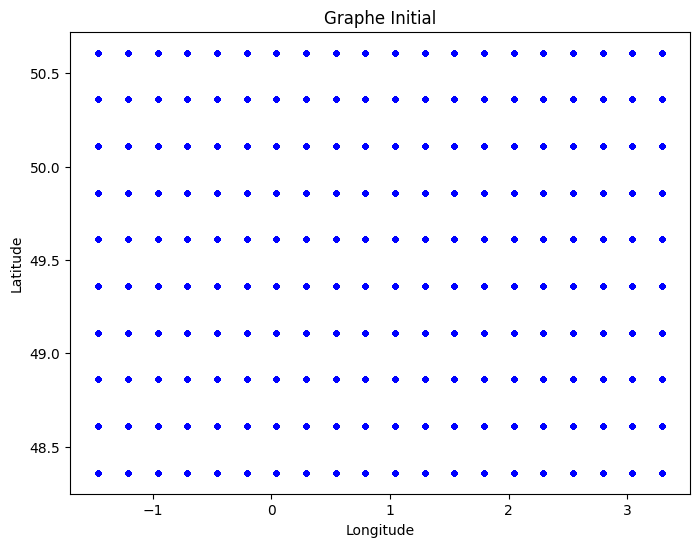

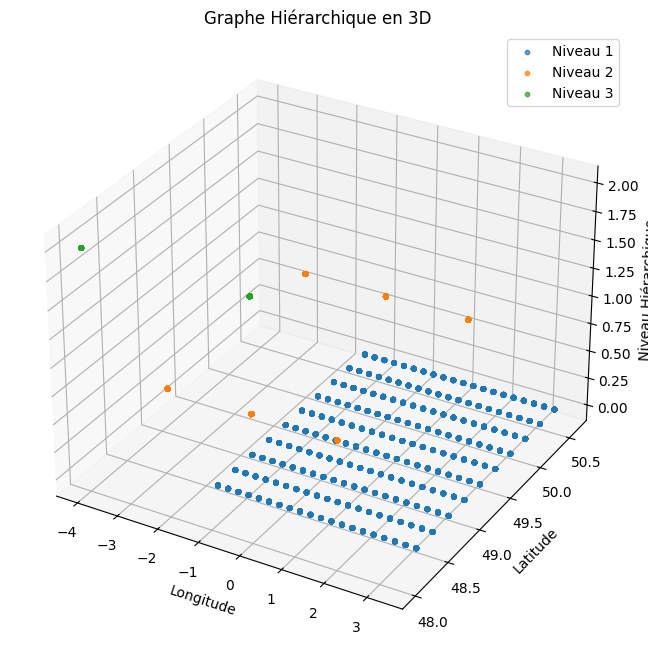

In [8]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Représentation du graphe initial
def plot_initial_graph(graph):
    coordinates = graph.x[:, :2].numpy()  # Extraire les coordonnées (latitude, longitude)
    plt.figure(figsize=(8, 6))
    plt.scatter(coordinates[:, 1], coordinates[:, 0], s=10, c='blue', alpha=0.7)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Graphe Initial")
    plt.show()

# Représentation du graphe hiérarchique en 3D
def plot_hierarchical_graph_3d(hierarchical_graphs):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for level, graph in enumerate(hierarchical_graphs):
        coordinates = graph.x[:, :2].numpy()  # Extraire les coordonnées (latitude, longitude)
        z = [level] * len(coordinates)  # Niveau hiérarchique comme coordonnée Z
        ax.scatter(coordinates[:, 1], coordinates[:, 0], z, s=10, label=f"Niveau {level + 1}", alpha=0.7)
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_zlabel("Niveau Hiérarchique")
    ax.set_title("Graphe Hiérarchique en 3D")
    plt.legend()
    plt.show()

# Appeler les fonctions pour afficher les graphes
plot_initial_graph(initial_graph)
plot_hierarchical_graph_3d(hierarchical_graphs)

## To Do (Optional): Experiment with Different Parameters:
We can test different values for spatial_radius and num_levels to optimize the graph structure.

In [9]:
merged_df

valid_time  latitude  longitude         t2m  number_x       u10  \
0    2024-10-01     50.61      -1.46  287.027130         0  5.891641   
1    2024-10-01     50.61      -1.21  286.772522         0  6.031213   
2    2024-10-01     50.61      -0.96  287.039825         0  6.910450   
3    2024-10-01     50.61      -0.71  287.251373         0  7.634367   
4    2024-10-01     50.61      -0.46  287.338379         0  8.157102   
...         ...       ...        ...         ...       ...       ...   
6195 2024-10-31     48.36       2.29  283.436798         0 -2.174011   
6196 2024-10-31     48.36       2.54  283.398285         0 -2.063164   
6197 2024-10-31     48.36       2.79  283.367462         0 -2.001111   
6198 2024-10-31     48.36       3.04  283.360077         0 -2.027885   
6199 2024-10-31     48.36       3.29  283.306671         0 -1.982038   

      number_y       v10  number  
0            0 -4.007300       0  
1            0 -3.749726       0  
2            0 -3.886445       0  
3            0 -4.007127       0  
4            0 -4.026770       0  
...        ...       ...     ...  
6195         0 -0.324510       0  
6196         0 -0.320021       0  
6197         0 -0.285348       0  
6198         0 -0.257127       0  
6199         0 -0.226397       0  

[6200 rows x 9 columns]

In [10]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

In [11]:
df = merged_df.copy()
graphs = []  # List to store graphs

for date, group in df.groupby("valid_time"):
    # Extract node features and positions
    coords = group[["latitude", "longitude"]].values
    node_features = group[["t2m", "u10", "v10"]].values

    # Build edges using KNN (e.g., k=5)
    adj_matrix = kneighbors_graph(coords, n_neighbors=5, mode="connectivity", include_self=False)
    edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)

    # Create a PyG graph
    graph = Data(x=x, edge_index=edge_index)

    graphs.append(graph)


/tmp/ipykernel_307182/1122635683.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)


In [13]:
print(f"Total graphs: {len(graphs)}")  
print(f"Nodes in first graph: {graphs[0].num_nodes}")  
print(f"Features per node: {graphs[0].x.shape[1]}")  # Should be 3 (t2m, u10, v10)


Total graphs: 31
Nodes in first graph: 200
Features per node: 3


In [ ]:
##HierarchicalGCNEncoder
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim

class HierarchicalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super(HierarchicalGCNEncoder, self).__init__()
        # Niveau bas (low-level features)
        self.low_conv1 = GCNConv(in_channels, hidden_channels)
        self.low_conv2 = GCNConv(hidden_channels, hidden_channels//2)
        
        # Niveau moyen (mid-level features)
        self.mid_conv1 = GCNConv(hidden_channels//2, hidden_channels//2)
        self.mid_conv2 = GCNConv(hidden_channels//2, hidden_channels//4)
        
        # Niveau haut (high-level/latent representation)
        self.high_conv1 = GCNConv(hidden_channels//4, hidden_channels//4)
        self.high_conv2 = GCNConv(hidden_channels//4, latent_dim)
        
    def forward(self, x, edge_index):
        # Niveau bas
        x_low = F.relu(self.low_conv1(x, edge_index))
        x_low = F.relu(self.low_conv2(x_low, edge_index))
        
        # Niveau moyen
        x_mid = F.relu(self.mid_conv1(x_low, edge_index))
        x_mid = F.relu(self.mid_conv2(x_mid, edge_index))
        
        # Niveau haut
        x_high = F.relu(self.high_conv1(x_mid, edge_index))
        z = self.high_conv2(x_high, edge_index)  # Représentation latente
        
        return z, (x_low, x_mid, x_high)  # Retourne aussi les features intermédiaires

class GCNDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_channels, out_channels):
        super(GCNDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)  # Predict (t2m, u10, v10)
        
    def forward(self, z, edge_index):
        x = F.relu(self.conv1(z, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.conv3(x, edge_index)
        return out  # Output shape: (num_nodes, 3)

# Initialisation avec la nouvelle architecture
encoder = HierarchicalGCNEncoder(in_channels=3, hidden_channels=64, latent_dim=16)
decoder = GCNDecoder(latent_dim=16, hidden_channels=32, out_channels=3)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    total_loss = 0
    for t in range(len(graphs) - 1):  # Train on all but last timestep
        data_t = graphs[t]  # Graph at time t
        data_t1 = graphs[t+1]  # Graph at time t+1
        
        optimizer.zero_grad()
        
        z, _ = encoder(data_t.x, data_t.edge_index)  # Encode (on ignore les features intermédiaires)
        out = decoder(z, data_t.edge_index)  # Decode
        
        loss = loss_fn(out, data_t1.x)  # Predict t2m, u10, v10
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

## **Graph Convolutional Network for Weather Forecasting**

#### Model Architecture

This implementation presents a Graph Convolutional Network designed for spatiotemporal weather prediction, specifically forecasting temperature (t2m) and wind components (u10, v10) across geographical locations.

##### Key Components

**GCN Encoder-Decoder Architecture**
- **Encoder**: Transforms input weather features into latent space representations
- **Decoder**: Recontruct the prediction for time t+1

In [33]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, latent_dim)  # Latent representation
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        z = self.conv3(x, edge_index)  # Latent variable z
        return z
    

class GCNDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_channels, out_channels):
        super(GCNDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)  # Predict (t2m, u10, v10)
        
    def forward(self, z, edge_index):
        x = F.relu(self.conv1(z, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.conv3(x, edge_index)
        return out  # Output shape: (num_nodes, 3)

import torch.optim as optim

encoder = GCNEncoder(in_channels=3, hidden_channels=32, latent_dim=16)
decoder = GCNDecoder(latent_dim=16, hidden_channels=32, out_channels=3)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    total_loss = 0
    for t in range(len(graphs) - 1):  # Train on all but last timestep
        data_t = graphs[t]  # Graph at time t
        data_t1 = graphs[t+1]  # Graph at time t+1
        
        optimizer.zero_grad()
        
        z = encoder(data_t.x, data_t.edge_index)  # Encode
        out = decoder(z, data_t.edge_index)  # Decode
        
        loss = loss_fn(out, data_t1.x)  # Predict t2m, u10, v10
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 381578.3374
Epoch 1, Loss: 18843.9893
Epoch 2, Loss: 11549.6532
Epoch 3, Loss: 11074.8155
Epoch 4, Loss: 11022.6198
Epoch 5, Loss: 11016.9065
Epoch 6, Loss: 11018.5713
Epoch 7, Loss: 11019.4434
Epoch 8, Loss: 11018.7311


Epoch 9, Loss: 11016.7931
Epoch 10, Loss: 11014.1680
Epoch 11, Loss: 11011.3264
Epoch 12, Loss: 11008.5854
Epoch 13, Loss: 11006.1085
Epoch 14, Loss: 11003.9616
Epoch 15, Loss: 11002.1490
Epoch 16, Loss: 11000.6454
Epoch 17, Loss: 10999.4211
Epoch 18, Loss: 10998.4422
Epoch 19, Loss: 10997.6724
Epoch 20, Loss: 10997.0067
Epoch 21, Loss: 10995.0598
Epoch 22, Loss: 10994.8777
Epoch 23, Loss: 10994.6151
Epoch 24, Loss: 10994.5133
Epoch 25, Loss: 10994.5005
Epoch 26, Loss: 10994.5673
Epoch 27, Loss: 10994.6973
Epoch 28, Loss: 10994.8699
Epoch 29, Loss: 10995.0634
Epoch 30, Loss: 10995.2525
Epoch 31, Loss: 10995.4128
Epoch 32, Loss: 10995.5145
Epoch 33, Loss: 10995.5320
Epoch 34, Loss: 10995.4434
Epoch 35, Loss: 10995.2288
Epoch 36, Loss: 10994.8798
Epoch 37, Loss: 10994.3968
Epoch 38, Loss: 10993.7902
Epoch 39, Loss: 10993.0799
Epoch 40, Loss: 10992.2924
Epoch 41, Loss: 10991.4608
Epoch 42, Loss: 10990.6143
Epoch 43, Loss: 10989.7809
Epoch 44, Loss: 10988.9828
Epoch 45, Loss: 10988.2383
Ep

In [34]:
def predict(graph_t, steps=1):
    """
    Predict the future values for `steps` time steps starting from time t.
    
    Args:
    - graph_t: The graph object at time t (contains node features and edge indices).
    - steps: The number of time steps to predict.
    
    Returns:
    - predictions: A list of predicted values for each step (t+1, t+2, ...)
    """
    predictions = []
    # Encode the input graph to get the latent variable z
    z = encoder(graph_t.x, graph_t.edge_index)
    
    # Perform predictions for the given number of steps
    for _ in range(steps):
        # Decode the latent variable to get the predicted output (t2m, u10, v10)
        out = decoder(z, graph_t.edge_index)
        
        # Store the prediction for this step
        predictions.append(out.detach().cpu().numpy())
        
        # Use the predicted output as input for the next time step
        z = encoder(out, graph_t.edge_index)  # Get the next latent variable
    
    return predictions


/tmp/ipykernel_307182/3212716590.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


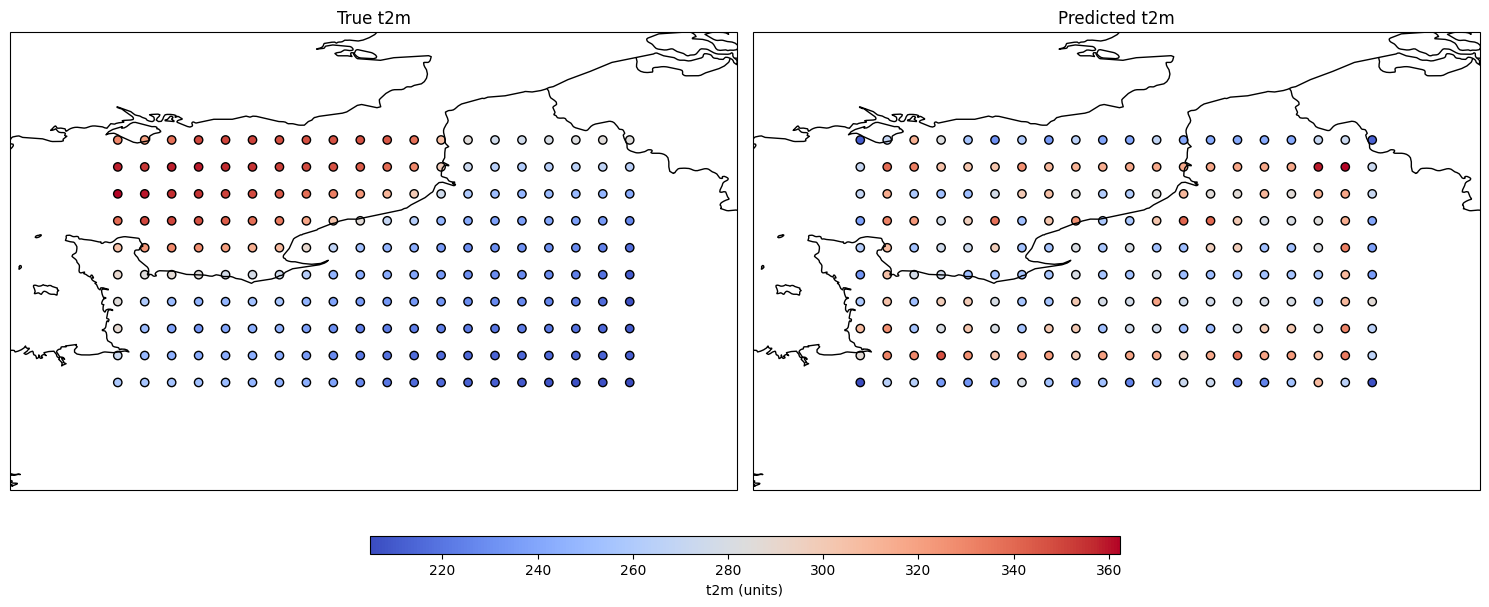

/tmp/ipykernel_307182/3212716590.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


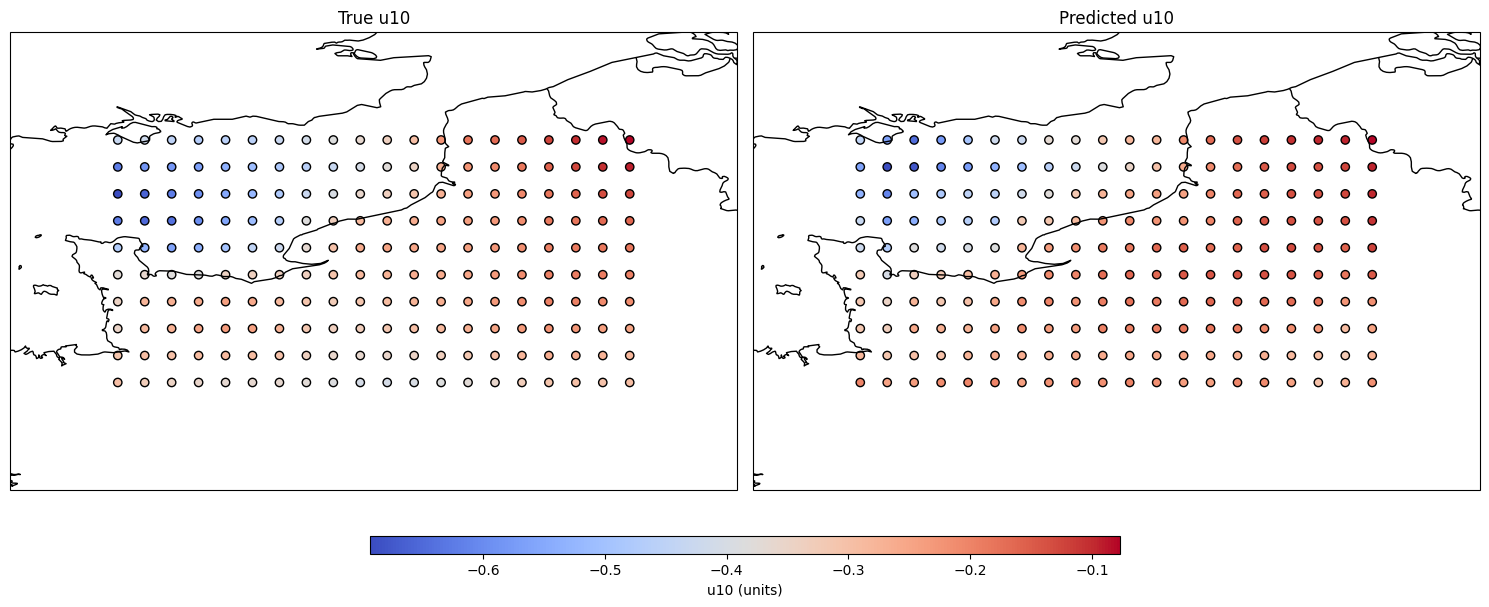

/tmp/ipykernel_307182/3212716590.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


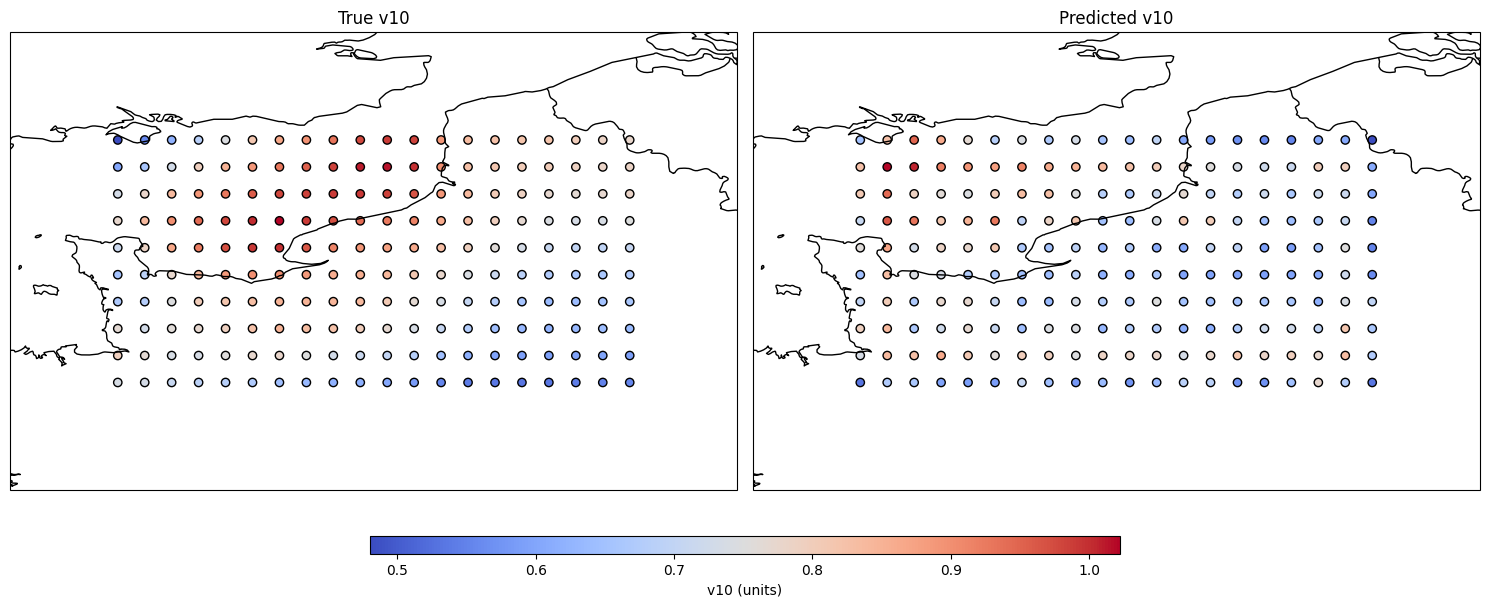

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch

# Select the last graph (latest date) for comparison
data_t1 = graphs[-1]  # True values
predicted_t1 = predict(graphs[-2], steps=1)[0]  # Get prediction from previous time step

# Extract coordinates
lats = df[df["valid_time"] == df["valid_time"].max()]["latitude"].values
lons = df[df["valid_time"] == df["valid_time"].max()]["longitude"].values

# Extract actual and predicted values for all variables
variables = ["t2m", "u10", "v10"]
actual_values = [data_t1.x[:, i].detach().cpu().numpy() for i in range(3)]
predicted_values = [predicted_t1[:, i] for i in range(3)]

# Plot the maps using Cartopy
for i, var in enumerate(variables):
    # Create a new figure for each variable
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # True and predicted values for the current variable
    actual = actual_values[i]
    predicted = predicted_values[i]
    
    for ax, data, title in zip(axes, [actual, predicted], [f"True {var}", f"Predicted {var}"]):
        ax.set_extent([min(lons)-1, max(lons)+1, min(lats)-1, max(lats)+1], crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        
        # Scatter plot of values
        scatter = ax.scatter(lons, lats, c=data, cmap="coolwarm", marker="o", edgecolors="black", transform=ccrs.PlateCarree())
        ax.set_title(title)
    
    # Add a colorbar for the current variable
    cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  # [left, bottom, width, height]
    fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label=f"{var} (units)")
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to make room for colorbar
    plt.show()

## **Variational Graph Convolutional Network for Spatiotemporal Forecasting**

#### Model Architecture Overview

This implementation presents a kind of **Variational Graph Convolutional Network** designed for probabilistic spatiotemporal forecasting

#### Architectural Details

##### Hierarchical Feature Processing

| Level        | Channels                 | Purpose                          |
|--------------|--------------------------|----------------------------------|
| **Low**      | `in → hidden → hidden/2` | Coarse feature extraction        |
| **Mid**      | `hidden/2 → hidden/4`    | Intermediate representation      |
| **High**     | `hidden/4 → latent`      | Probabilistic latent space       |

This method is used for probabilistic Forecasting and allows us to :
- Encodes uncertainty through μ and logvar parameters
- Enables generation of multiple plausible futures
- Multi-Scale Processing:  by teh fact that hierarchical architecture captures features at different scales. And progressive channel reduction focuses information

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super(VariationalGCNEncoder, self).__init__()
        
        # Low level
        self.low_conv1 = GCNConv(in_channels, hidden_channels)
        self.low_conv2 = GCNConv(hidden_channels, hidden_channels//2)
        
        # Mid level
        self.mid_conv1 = GCNConv(hidden_channels//2, hidden_channels//2)
        self.mid_conv2 = GCNConv(hidden_channels//2, hidden_channels//4)
        
        # High level (for mu and logvar)
        self.high_conv_mu = GCNConv(hidden_channels//4, latent_dim)
        self.high_conv_logvar = GCNConv(hidden_channels//4, latent_dim)
        
    def forward(self, x, edge_index):
        # Hierarchical propagation
        x_low = F.relu(self.low_conv1(x, edge_index))
        x_low = F.relu(self.low_conv2(x_low, edge_index))
        
        x_mid = F.relu(self.mid_conv1(x_low, edge_index))
        x_mid = F.relu(self.mid_conv2(x_mid, edge_index))
        
        # Distribution parameters
        mu = self.high_conv_mu(x_mid, edge_index)
        logvar = self.high_conv_logvar(x_mid, edge_index)
        
        return mu, logvar

class GCNDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_channels, out_channels):
        super(GCNDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, z, edge_index):
        x = F.relu(self.conv1(z, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.conv3(x, edge_index)
        return out

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

class TemporalGCNPredictor:
    def __init__(self, in_channels, hidden_channels, latent_dim, out_channels):
        self.encoder = VariationalGCNEncoder(in_channels, hidden_channels, latent_dim)
        self.decoder = GCNDecoder(latent_dim, hidden_channels, out_channels)
        self.optimizer = optim.Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()), 
            lr=0.001
        )
        
    def train(self, graphs, epochs=100):
        self.encoder.train()
        self.decoder.train()
        
        for epoch in range(epochs):
            total_loss = 0
            for t in range(len(graphs) - 1):
                data_t = graphs[t]
                data_t1 = graphs[t+1]
                
                self.optimizer.zero_grad()
                
                # Variational encoding
                mu, logvar = self.encoder(data_t.x, data_t.edge_index)
                z = reparameterize(mu, logvar)
                
                # Decoding to predict t+1
                recon_x = self.decoder(z, data_t.edge_index)
                
                # Loss calculation
                loss = loss_function(recon_x, data_t1.x, mu, logvar)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
    
    def predict_next_step(self, current_graph):
        """Predict the next time step (t+1) given current graph (t)"""
        self.encoder.eval()
        self.decoder.eval()
        
        with torch.no_grad():
            mu, logvar = self.encoder(current_graph.x, current_graph.edge_index)
            z = reparameterize(mu, logvar)
            predicted_next = self.decoder(z, current_graph.edge_index)
            
        return predicted_next
    
    def predict_sequence(self, initial_graph, steps):
        """Predict multiple future steps recursively"""
        predictions = []
        current_graph = initial_graph
        
        for _ in range(steps):
            next_pred = self.predict_next_step(current_graph)
            
            # Create a new graph with the predicted features
            # (assuming same edge structure remains)
            predicted_graph = current_graph.clone()
            predicted_graph.x = next_pred
            
            predictions.append(predicted_graph)
            current_graph = predicted_graph
            
        return predictions

In [22]:
# Assuming 'graphs' is your list of temporal graph data
predictor = TemporalGCNPredictor(
    in_channels=3, 
    hidden_channels=64, 
    latent_dim=16, 
    out_channels=3
)
predictor.train(graphs, epochs=100)

Epoch 0, Loss: 5103863654.0000
Epoch 1, Loss: 338867894.5000
Epoch 2, Loss: 84527832.2500
Epoch 3, Loss: 21742337.9375
Epoch 4, Loss: 19391527.8750
Epoch 5, Loss: 18731203.8125
Epoch 6, Loss: 18214791.3125
Epoch 7, Loss: 17703163.9375
Epoch 8, Loss: 17211590.7500
Epoch 9, Loss: 16754610.6875
Epoch 10, Loss: 16292596.9688
Epoch 11, Loss: 15879707.7188
Epoch 12, Loss: 15430483.6875
Epoch 13, Loss: 15079404.4062
Epoch 14, Loss: 14699133.8125
Epoch 15, Loss: 14351020.6562
Epoch 16, Loss: 14059699.7812
Epoch 17, Loss: 13718434.8750
Epoch 18, Loss: 13414916.6562
Epoch 19, Loss: 13133775.6250
Epoch 20, Loss: 12864749.2812
Epoch 21, Loss: 12608049.2188
Epoch 22, Loss: 12340016.0625
Epoch 23, Loss: 12143680.7500
Epoch 24, Loss: 11938994.6562
Epoch 25, Loss: 11714731.9688
Epoch 26, Loss: 11556895.5938
Epoch 27, Loss: 11345116.1250
Epoch 28, Loss: 11196979.9688
Epoch 29, Loss: 11054847.6562
Epoch 30, Loss: 10880762.5000
Epoch 31, Loss: 10738415.9062
Epoch 32, Loss: 10613460.8438
Epoch 33, Loss: 1

In [23]:
# Predict t+1 from t
current_graph = graphs[-1]  # most recent graph
next_step_pred = predictor.predict_next_step(current_graph)

In [24]:
# Predict 5 future steps
future_predictions = predictor.predict_sequence(current_graph, steps=5)

In [31]:
def plot_predictions_with_difference(graphs, predictor, df, variable_names=["t2m", "u10", "v10"]):
    """Plot true, predicted, and difference maps"""
    
    # Get data and predictions
    data_t = graphs[-2]
    data_t1 = graphs[-1]
    predicted_t1 = predictor.predict_next_step(data_t).detach().cpu().numpy()
    actual_t1 = data_t1.x.detach().cpu().numpy()
    
    # Get coordinates
    latest_time = df["valid_time"].max()
    lats = df[df["valid_time"] == latest_time]["latitude"].values
    lons = df[df["valid_time"] == latest_time]["longitude"].values
    
    for i, var in enumerate(variable_names):
        fig = plt.figure(figsize=(20, 6))
        axes = [plt.subplot(1, 3, j+1, projection=ccrs.PlateCarree()) for j in range(3)]
        
        # Set map extent
        pad = 1.5
        extent = [min(lons)-pad, max(lons)+pad, min(lats)-pad, max(lats)+pad]
        
        # Data to plot
        actual = actual_t1[:, i]
        predicted = predicted_t1[:, i]
        difference = actual - predicted
        
        for ax, data, title in zip(axes, 
                                 [actual, predicted, difference],
                                 [f"True {var}", f"Predicted {var}", "Difference (True - Pred)"]):
            
            ax.set_extent(extent, crs=ccrs.PlateCarree())
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS)
            
            if "Difference" in title:
                # Use divergent colormap for difference plot
                max_diff = max(abs(difference.min()), abs(difference.max()))
                scatter = ax.scatter(lons, lats, c=data, cmap="RdBu_r", 
                                    vmin=-max_diff, vmax=max_diff, s=50,
                                    transform=ccrs.PlateCarree())
            else:
                # Use sequential colormap for true/predicted
                scatter = ax.scatter(lons, lats, c=data, cmap="viridis", 
                                    s=50, transform=ccrs.PlateCarree())
            
            ax.set_title(title, fontsize=12)
        
        # Add colorbar for each row
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
        fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        
        plt.suptitle(f"{var} Prediction Analysis", y=1.05, fontsize=14)
        plt.show()

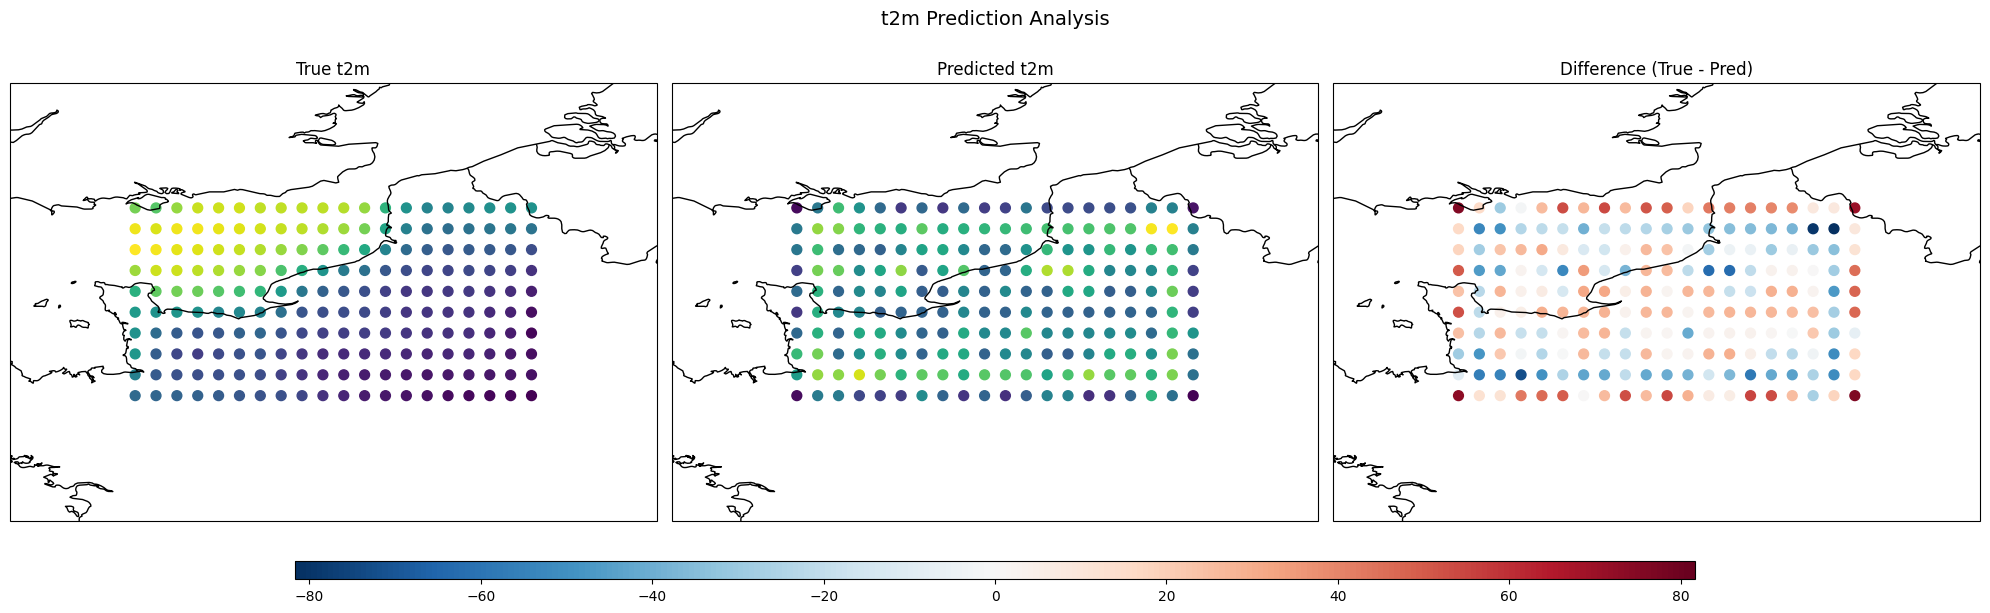

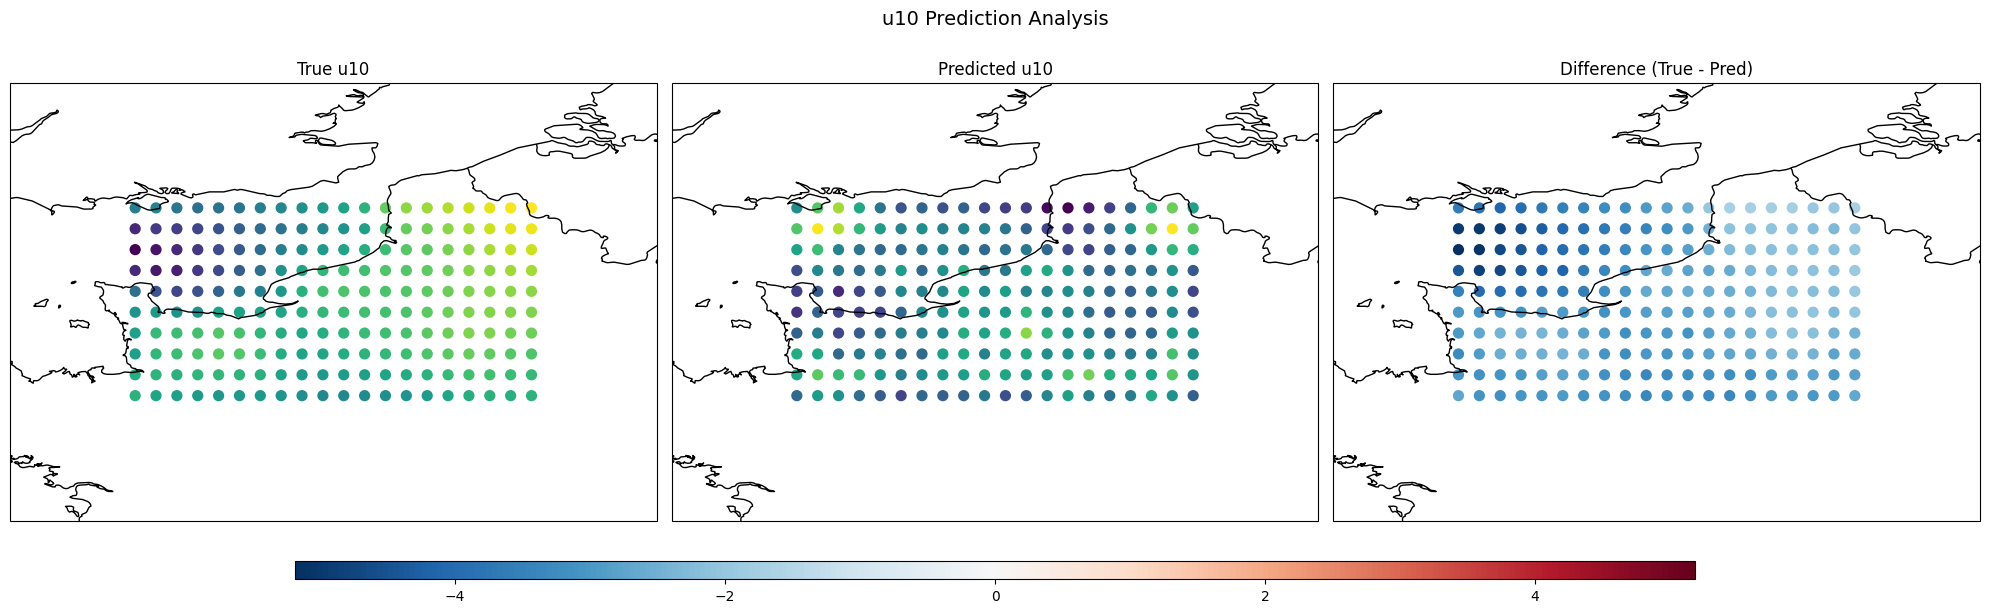

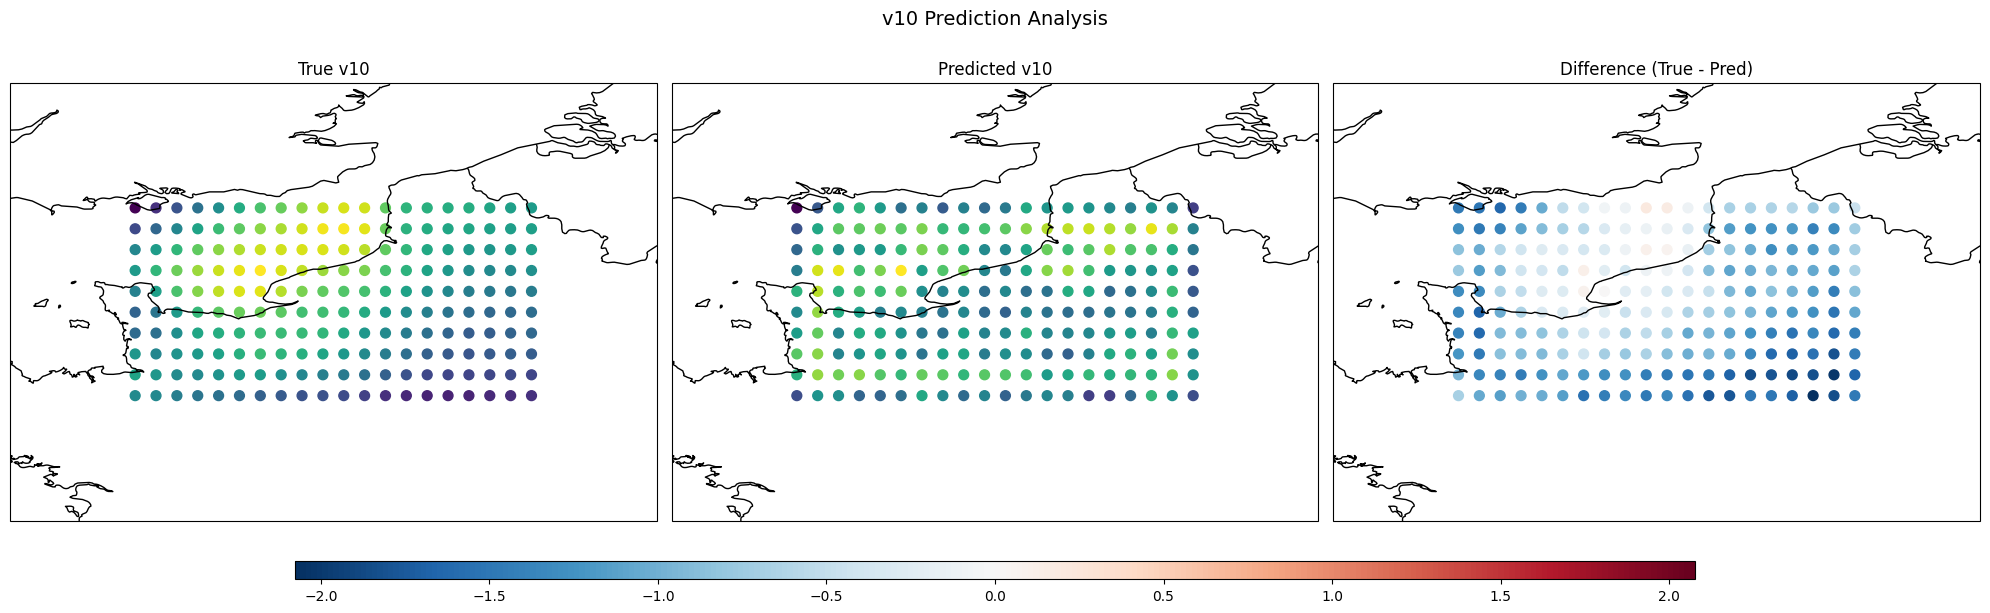

In [30]:
plot_predictions_with_difference(graphs, predictor, df)